There is some oscillatory behaviour in the "default" GP kernels, but I'm not sure where this comes from. Is it caused by conditioning?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

In [3]:
def squared_exponential_kernel(t, tp, sigma=1, l=1):
    return sigma**2*np.exp(-(t-tp)**2/(2*l**2))

In [4]:
def stitch_kernel(t, tp, sigma_stitch, n, t_ref):
    if t == tp:
        return sigma_stitch**2*np.exp(n*(t-t_ref))
    else:
        return 0

In [5]:
N = 250
x = np.linspace(-5, 5, N)

In [6]:
Sigma = np.zeros((N, N))
for i, t in enumerate(x):
    for j, tp in enumerate(x):
        Sigma[i, j] = squared_exponential_kernel(t, tp, sigma=1, l=0.2)

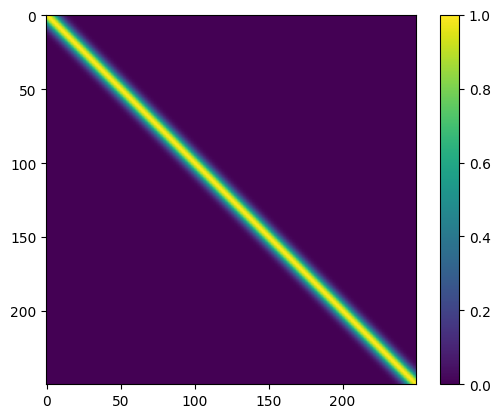

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.imshow(Sigma)
cbar = ax.figure.colorbar(ax.imshow(Sigma), ax=ax, cmap='viridis', )

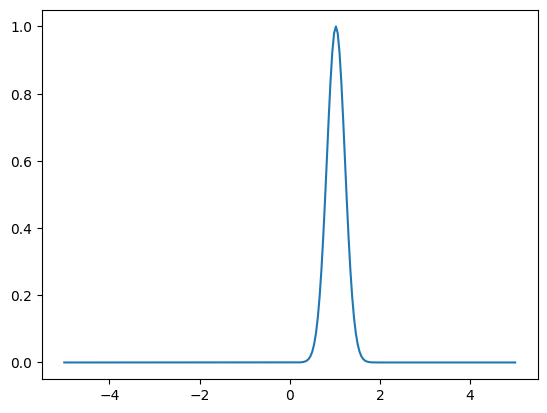

In [8]:
fig, ax = plt.subplots()
ax.plot(x, Sigma[:, 150]);

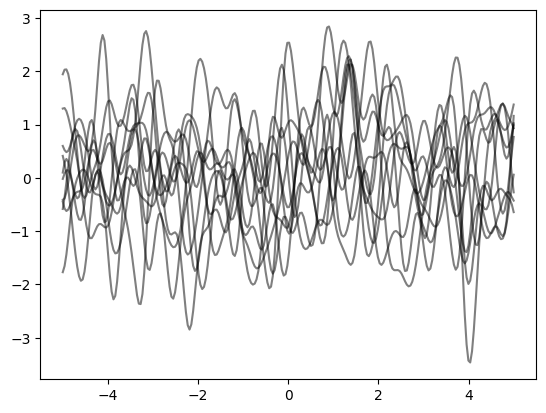

In [9]:
fig, ax = plt.subplots()

repeats = 10
for _ in range(repeats):
    ax.plot(x, rng.multivariate_normal(np.zeros(N), Sigma), alpha=0.5, c='k')

In [10]:
training_x = np.linspace(2, 5, num=60)
training_y = 2*np.ones_like(training_x)

training_dim = len(training_x)

xp = np.append(training_x, x)

In [11]:
# what if I want a non-zero mean?
mu = 0

Sigma = np.zeros((N + training_dim, N + training_dim))

for i, t in enumerate(xp):
    for j, tp in enumerate(xp):
        Sigma[i, j] = squared_exponential_kernel(t, tp, sigma=1, l=0.2)

In [12]:
training_x

array([2.        , 2.05084746, 2.10169492, 2.15254237, 2.20338983,
       2.25423729, 2.30508475, 2.3559322 , 2.40677966, 2.45762712,
       2.50847458, 2.55932203, 2.61016949, 2.66101695, 2.71186441,
       2.76271186, 2.81355932, 2.86440678, 2.91525424, 2.96610169,
       3.01694915, 3.06779661, 3.11864407, 3.16949153, 3.22033898,
       3.27118644, 3.3220339 , 3.37288136, 3.42372881, 3.47457627,
       3.52542373, 3.57627119, 3.62711864, 3.6779661 , 3.72881356,
       3.77966102, 3.83050847, 3.88135593, 3.93220339, 3.98305085,
       4.03389831, 4.08474576, 4.13559322, 4.18644068, 4.23728814,
       4.28813559, 4.33898305, 4.38983051, 4.44067797, 4.49152542,
       4.54237288, 4.59322034, 4.6440678 , 4.69491525, 4.74576271,
       4.79661017, 4.84745763, 4.89830508, 4.94915254, 5.        ])

In [13]:
Sigma_stitch = np.zeros((training_dim, training_dim))
for i, t in enumerate(training_x):
    for j, tp in enumerate(training_x):
        Sigma_stitch[i, j] = stitch_kernel(t, tp, sigma_stitch=0.05, n=-5, t_ref=5)

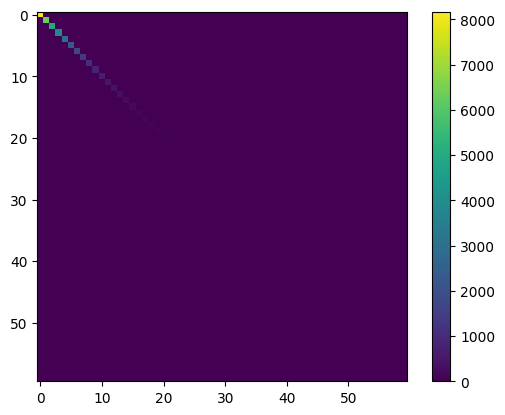

In [14]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.imshow(Sigma_stitch)
cbar = ax.figure.colorbar(ax.imshow(Sigma_stitch), ax=ax, cmap='viridis', )

In [15]:
# Then we need to condition this thing, and in the process make it dimenion N
# again.

sigma_XX = Sigma[training_dim:, training_dim:]
sigma_YY = Sigma[:training_dim, :training_dim]

sigma_XY = Sigma[training_dim:, :training_dim]
sigma_YX = Sigma[:training_dim, training_dim:]

# Add an uncertainty to the training data
sigma_YY += Sigma_stitch

sigma_YY_inv = np.linalg.inv(sigma_YY)

mup = mu + sigma_XY @ sigma_YY_inv @ (training_y - mu)
Sigmap = sigma_XX - sigma_XY @ sigma_YY_inv @ sigma_YX

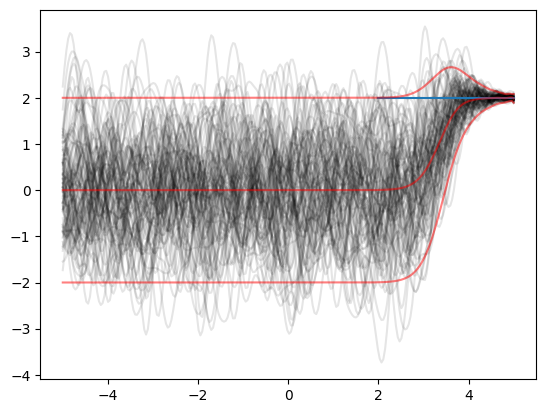

In [16]:
fig, ax = plt.subplots()

repeats = 100

for _ in range(repeats):
    ax.plot(x, rng.multivariate_normal(mup, Sigmap), alpha=0.1, c='k')

ax.plot(training_x, training_y, c='C0', zorder=10)

ax.plot(x, mup, c='r', zorder=10, alpha=0.5)
ax.plot(x, mup + 2*np.sqrt(np.diag(Sigmap)), c='r', zorder=10, alpha=0.5)
ax.plot(x, mup - 2*np.sqrt(np.diag(Sigmap)), c='r', zorder=10, alpha=0.5);

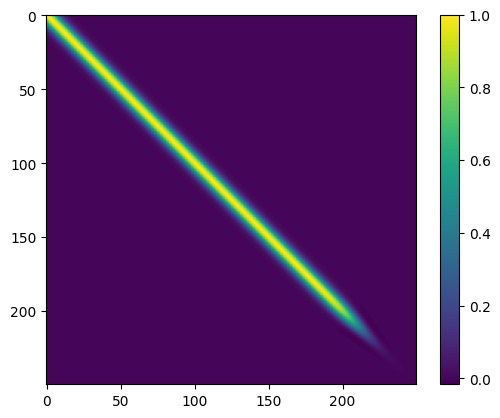

In [17]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.imshow(Sigmap)
cbar = ax.figure.colorbar(ax.imshow(Sigmap), ax=ax, cmap='viridis', )

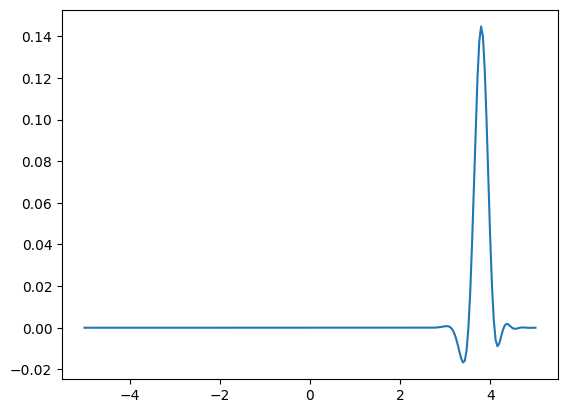

In [19]:
fig, ax = plt.subplots()
ax.plot(x, Sigmap[:, 220]);